In [109]:
from mnist_reader import load_mnist
from easydict import EasyDict as edict

import tensorflow as tf
import torch
import torch.optim as optim
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
#plt.style.use('ggplot')

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Scale
transform = Compose([
        Scale(64),
        ToTensor(),
])
mnist = MNIST('data', train=False, transform=transform, download=True)

In [51]:
mb_size = 64
dim = 64
out_dim = 28*28
z_dim = 100
nc = 1
G_fs = 64
D_fs = 64

In [52]:
X_train, y_train = load_mnist('data', kind='train')
X_test, y_test = load_mnist('data', kind='t10k')

X_train = X_train[0:64*10]

X_train = torch.from_numpy(X_train).float() / 256
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test).float() / 256
y_test = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train, y_train) 
test_dataset = TensorDataset(X_test, y_test) 

AssertionError: 

In [53]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.stage1 = nn.Linear(z_dim, 4*4*4*dim)
        self.conv1 = nn.ConvTranspose2d(4*dim, 2*dim, 5)
        self.conv2 = nn.ConvTranspose2d(2*dim, dim, 5)
        self.conv3 = nn.ConvTranspose2d(dim, 1, 8, stride=2)
        
    def forward(self, z):
        h = F.relu(self.stage1(z))
        #print(z.size())
        h = h.view(-1, 4*dim, 4, 4)
        #print(h.size())
        h = F.relu(self.conv1(h))
        #print(h.size())
        h = h[:, :, :7, :7]
        #print(h.size())
        h = F.relu(self.conv2(h))
        #print(h.size())
        h = F.relu(self.conv3(h))
        #print(h.size())
        h = F.sigmoid(h)
        #print(h.size())
        out = h.view(-1, out_dim)
        #print(out.size())
        return out
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, dim, 5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(dim, dim*2, 5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(dim*2, dim*4, 5, stride=2, padding=2)
        self.flat = nn.Linear(4*4*4*dim, 1)
        
    def forward(self, X):
        h = X.view(-1, 1, 28, 28)
        h = F.relu(self.conv1(h))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = h.view(-1, 4*4*4*dim)
        out = self.flat(h).view(-1)
        return out
    
    def grad_pen(self, real_data, fake_data):
        real_data = real_data.view(real_data.size(0), -1)
        fake_data = fake_data.view(fake_data.size(0), -1)
        alpha = torch.rand(mb_size, 1).cuda()
        alpha = alpha.expand(real_data.size())

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        interpolates = Variable(interpolates, requires_grad=True).cuda()

        disc_interpolates = self(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 1
        return gradient_penalty

In [54]:
G = Generator()
G.cuda()
D = Discriminator()
D.cuda()
z = Variable(torch.ones(mb_size, z_dim))
g = G(z)
d = D(g)
d.size()
D.grad_pen(d, d)

TypeError: torch.addmm received an invalid combination of arguments - got (int, torch.cuda.FloatTensor, int, torch.FloatTensor, torch.cuda.FloatTensor, out=torch.cuda.FloatTensor), but expected one of:
 * (torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)


In [127]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.relu(self.deconv4(x))
        x = F.sigmoid(self.deconv5(x))

        return x
    
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

    def normal_init(m, mean, std):
        if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            m.weight.data.normal_(mean, std)
            m.bias.data.zero_()
        
    def grad_pen(self, real_data, fake_data):
        real_data = real_data.view(mb_size, -1)
        fake_data = fake_data.view(mb_size, -1)
        real_data = real_data.view(real_data.size(0), -1)
        fake_data = fake_data.view(fake_data.size(0), -1)
        alpha = torch.rand(mb_size, 1).cuda()
        alpha = alpha.expand(real_data.size())

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        interpolates = Variable(interpolates, requires_grad=True).cuda()

        interpolates = interpolates.view(mb_size, 1, 64, 64)
        disc_interpolates = self(interpolates)

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 1
        return gradient_penalty

In [128]:
G = Generator()
G.cuda()
#G.weight_init()
D = Discriminator()
D.cuda()
#D.weigth_init()

G_solver = optim.Adamax(G.parameters(), lr=1e-4)
D_solver = optim.SGD(D.parameters(), lr=1e-4)

#loader = DataLoader(X_train, batch_size=64, drop_last=True)
loader = DataLoader(mnist, mb_size, drop_last=True)

one = torch.FloatTensor([1]).cuda()
mone = one * -1

In [129]:
e_bar = tqdm_notebook(range(10000))
D_losses = []
G_losses = []
for _ in e_bar:
    D_loss_avg = 0
    G_loss_avg = 0
    
    b_bar = tqdm_notebook(loader, leave=False)
    
    for X, _ in b_bar:
        X = Variable(X).cuda()
        for iter_d in range(1):
            for p in D.parameters():
                p.requires_grad = True  
            D.zero_grad()
            D_real = D(X)
            D_real = D_real.mean()
            # print D_real
            D_real.backward(mone)

            # train with fake
            z = Variable(torch.randn(mb_size, z_dim), volatile=True).cuda()
            z = z.view(-1, 100, 1, 1)
            G_sample = Variable(G(z).data)
            D_fake = D(G_sample)
            D_fake = D_fake.mean()
            D_fake.backward(one)

            # train with gradient penalty
            gp = D.grad_pen(X.data, G_sample.data)
            gp.backward()

            D_cost = D_fake - D_real + gp
            Wasserstein_D = D_real - D_fake
            D_solver.step()
            
            D_loss_avg += D_cost.data[0]
            
            b_bar.set_postfix(D_loss = F_cost)
            
            
        for p in D.parameters():
            p.requires_grad = False  # to avoid computation
        G.zero_grad()

        z = Variable(torch.randn(mb_size, z_dim)).cuda()
        z = z.view(-1, 100, 1, 1)
        G_sample = G(z)
        G_loss = D(G_sample)
        G_loss = G_loss.mean()
        G_loss.backward(mone)
        G_cost = -G_loss
        G_solver.step()
        
        G_loss_avg += G_cost.data[0]
        
    D_losses.append(D_loss_avg / len(loader))
    G_losses.append(G_loss_avg / len(loader))
    
    D_loss_avg = 0
    G_loss_avg = 0
    
    e_bar.set_postfix(
        D_loss = D_losses[-1],
        G_loss = G_losses[-1]
    )
        
        

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 6

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 6

torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 64, 64])
torch.Size([64, 1, 6

KeyboardInterrupt: 

(1, 64, 64)
float32


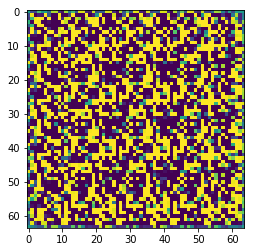

In [133]:
def show_imgs():
    z = Variable(torch.randn(mb_size, z_dim)).cuda().view(-1, 100, 1, 1)
    G_sample = G(z).data.cpu().numpy()
    G_sample = G_sample.reshape(-1, 64, 64)[0:1]
    print(G_sample.shape)
    print(G_sample.dtype)
    for x in G_sample:
        plt.figure()
        plt.imshow(x)
    plt.show()
    
show_imgs()